# Imbalanced Classification

Version 007.b

References:
+ Machine Learning Mastery book set "Imbalanced Classification"


In [1]:
# Python 3.7.3
############################################
# INCLUDES
############################################

# !!! Always use the same initilization to randomness for purposes of evaluating training quality.
# !!! If you allow for a completely random value every-time you will get different results.
# !!! The nature of a neural layer is stochastic assignment of weights to each layer
# seed the pseudorandom number generator
SEED_INIT = 7
from random import seed
seed(SEED_INIT)

from random import random
from random import randint

#libraries specific to this example
import tensorflow as tf
tf.random.set_seed(SEED_INIT)

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model

from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

#existing trained model
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16

# hyperparameter optimization
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import backend
from tensorflow.keras.backend import clear_session

from tensorflow.keras.optimizers import SGD

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

#Data Science Libraries
import numpy as np
from numpy import zeros
from numpy import asarray
from numpy import save
from numpy import savez_compressed
import pandas as pd
from pandas import read_csv
import scipy as sp
import scipy.ndimage

#used for "by-hand" processing of incoming data and grid search of hyper-parameters
#note that GridSearchCV DOES NOT support GPU's.  If you try you will get spurious error messages.
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score


#read and show images, plotting libraries
from matplotlib import pyplot
from matplotlib.image import imread
import matplotlib as mpl
import matplotlib.pyplot as plt
#import the PIL (Python Image Library)
import PIL
from PIL import Image

from array import *

# seed the pseudorandom number generator
from random import seed
from random import random
from random import randint

#a set of libraries that perhaps should always be in Python source
import os 
from os import listdir

import datetime
import sys
import gc
import getopt
import inspect
import math
import warnings
import types

#a darn useful library for creating paths and one I recommend you load to your environment
from pathlib import Path

# can type in the python console `help(name of function)` to get the documentation
from pydoc import help         

#Import a custom library, in this case a fairly useful logging framework
debug_lib_location = Path("./")
sys.path.append(str(debug_lib_location))
import debug

warnings.filterwarnings('ignore')               # don't print out warnings


root_location="/projects/tods-rt/ML";

In [2]:
############################################
#JUPYTER NOTEBOOK OUTPUT CONTROL / FORMATTING
############################################
#set floating point to 4 places to things don't run loose
pd.options.display.float_format = '{:,.4f}'.format
np.set_printoptions(precision=4)

# Variable declaration

In [3]:
############################################
# GLOBAL VARIABLES
############################################
DEBUG = 1                            #General ledger output so you know what's happening.
DEBUG_DATA = 1                       #Extremely verbose output, change to zero (0) to supress the volume of output.

# CODE CONSTRAINTS
VERSION_NAME    = "MLImbalancedClassification"
VERSION_ACRONYM = "ML-IMBL"
VERSION_MAJOR   = 0
VERSION_MINOR   = 0
VERSION_RELEASE = "7b"
VERSION_TITLE   = VERSION_NAME + " (" + VERSION_ACRONYM + ") " + str(VERSION_MAJOR) + "." + str(VERSION_MINOR) + "." + str(VERSION_RELEASE) + " generated SEED."

ENCODING  ="utf-8"
############################################
# GLOBAL CONSTANTS
############################################
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

############################################
# APPLICATION VARIABLES
############################################
ENCODING  ="utf-8"

SEED_INIT = 7

############################################
# GLOBAL CONFIGURATION
############################################
os.environ['PYTHONIOENCODING']=ENCODING

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## General Function Declaration

In [4]:
############################################
# WARNING / ERROR Management
############################################
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()


############################################
# FUNCTIONS
############################################

def prototype(incMonth):

    debug.msg_info("Entering {}.{}".format(__name__, inspect.stack()[0][3]))
    debug.msg_info("The month you passed in was " + str(incMonth))
    debug.msg_info("Exiting {}.{}".format(__name__, inspect.stack()[0][3]))
    return 1

def lib_diagnostics():
    debug.msg_debug("System version    #:{:>12}".format(sys.version))
    netcdf4_version_info = nc.getlibversion().split(" ")
    debug.msg_debug("netCDF4 version   #:{:>12}".format(netcdf4_version_info[0]))
    debug.msg_debug("Matplotlib version#:{:>12}".format(matplt.__version__))
    debug.msg_debug("Numpy version     #:{:>12}".format(np.__version__))
    debug.msg_debug("Pandas version    #:{:>12}".format(pd.__version__))
    debug.msg_debug("SciPy version     #:{:>12}".format(sp.__version__))

    return


def get_full_version():

    resultant = str(VERSION_NAME) + "  v" + str(VERSION_MAJOR) + "." + str(VERSION_MINOR) + "." + str(VERSION_RELEASE)
    return resultant

def get_version():

    resultant = str(VERSION_MAJOR) + "." + str(VERSION_MINOR) + "." + str(VERSION_RELEASE)
    return resultant

def printversion():

    print(get_full_version())

def printusage():

    print("")
    printversion()
    print("  -v, --version    prints the version of this software package.")
    print("")
    print("  * - indicates required argument.")

######################################################################
#Support routines to see columns in DataFrames
######################################################################
def show_columns_plain(inc_ary):
    new_ary = []
    for col in inc_ary:
        new_ary.append(np.char.lower(col))
    new_ary.sort
    myOutputString = " "
    for col in new_ary:
        myOutputString = myOutputString + " " + str(col)
    return myOutputString

def show_columns_true(inc_ary):
    new_ary = []
    for col in inc_ary:
        new_ary.append(col)
    new_ary.sort
    myOutputString = " "
    for col in new_ary:
        myOutputString = myOutputString + " " + str(col)
    return myOutputString

######################################################################
#Input Validation
######################################################################
# valid string:
#  We don't want the following:
#   - at the start of the file name (might be construed as a switch)
#  $, &, |, ;, <, >, `, !, *, ", \ (to start with)
###
def validstring(testsubject):

    if testsubject[0] == "-":
        return 0
    elif "$" in testsubject or "&" in testsubject or "|" in testsubject:
        return 0
    elif ";" in testsubject or "`" in testsubject or "!" in testsubject:
        return 0
    elif "*" in testsubject or '"' in testsubject or "\\" in testsubject:
        return 0
    else:
        return 1
        

In [5]:
# %load ./libs.py
#Title:     Displays the libraries in current use.
#Objective: Invocation is intended as function calls within another program.
#Assumptions:
#           1. Should be stored in standardized location such as:
#                      /p/home/{user_name}/usr/PYTHONLIB
#           2. Developer loads the module (Jupyter Lab).
#Pre-Requisites:
#           1. Python v3.*
#           2. Jupyter Lab / Notebook (%load libs.py)
#Usage:
#       %load libs.py
#       find_loaded_modules().HTML
#
#Version History:
# ------------------------------------------------------------------------
# Version   Date       Modification                              Author
# ------------------------------------------------------------------------
# 1.0       2020/04/29 Inception                                 Radiance
# ------------------------------------------------------------------------
# ------------------------------------------------------------------------


#######################################################################
#LIBRARIES
#######################################################################
import os
import types

def module_version(mod):
    '''Return version string for module *mod*, or nothing if
    it doesn't have a "version" or "__version__" attribute.'''
    version = []
    if hasattr(mod, '__dict__'):
        keys = []
        for key in mod.__dict__.keys():
            if key.lower() == 'version' or key.lower() == '__version__':
                v = mod.__dict__[key]
                if (str):
                    if isinstance(v, str):
                        version.append(v)
                else:
                    version.append("No version")
        if keys:
            print (mod, keys)
    if version:
        return ', '.join(version)
    else:
        return ''

def find_loaded_modules(only_versioned_modules=True):

    def list_of_lists_to_HTML(lists, header_row=None):
        '''Convert a list of a list of strings to a HTML table.'''
        s = '<table>'
        if header_row:
            s += '\n\t<tr>\n\t\t'
            s += ''.join(['<th>%s</th>' % item for item in header_row])
            s += '\n\t</tr>'
        for inner_list in lists:
            s += '\n\t<tr>\n\t\t'
            s += ''.join(['<td>%s</td>' % item for item in inner_list])
            s += '\n\t</tr>'
        s += '\n</table>'
        return s
    
    class LoadedModules(list):
        '''Very simple wrapper for a list of lists of strings, with an attribute
        for display in IPython Notebooks.'''
        def __init__(self, *args, **kwargs):
            list.__init__(self, *args, **kwargs)
            
        @property
        def HTML(self):
            from IPython.display import HTML
            return HTML(
                    list_of_lists_to_HTML(
                            self, header_row=['Name', 'Version']))
                    
    objs = LoadedModules()
    for i, mod in enumerate(globals().values()):
        if isinstance(mod, types.ModuleType):
            if hasattr(mod, '__name__'):
                name = mod.__name__
            else:
                name = ''
            
            version = module_version(mod)
            
            objs.append([mod.__name__, version])
    objs.sort(key=lambda r: r[0])
    return objs


# Some Terms

+ Majority class - 0 - Negative class - the class with the most samples
+ Minority class - 1 - Positive class - the class with the least samples

# Impact of Imbalanced Classification with 4 Examples

Size=100, Ratio=Counter({0: 99, 1: 1})
Size=1000, Ratio=Counter({0: 990, 1: 10})
Size=10000, Ratio=Counter({0: 9900, 1: 100})
Size=100000, Ratio=Counter({0: 99000, 1: 1000})


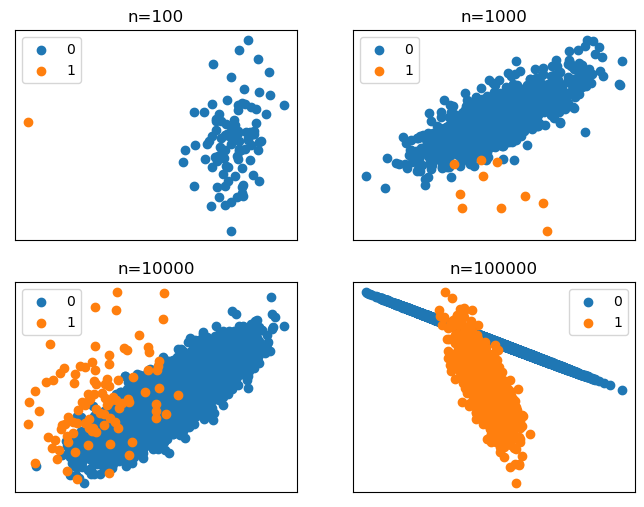

In [6]:
# vary the dataset size for a 1:100 imbalanced dataset
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where
# dataset sizes
sizes = [100, 1000, 10000, 100000]
# create and plot a dataset with each size
for i in range(len(sizes)):
    # determine the dataset size
    n = sizes[i];
    # create the dataset
    X, y = make_classification(n_samples=n, n_features=2, n_redundant=0,
        n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1);
    # summarize class distribution
    counter = Counter(y);
    print('Size=%d, Ratio=%s' % (n, counter));
    # define subplot
    pyplot.subplot(2, 2, 1+i);
    pyplot.title('n=%d' % n);
    pyplot.xticks([]);
    pyplot.yticks([]);
    # scatter plot of examples by class label
    for label, _ in counter.items():
        row_ix = where(y == label)[0];
        pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label));
    pyplot.legend();
# show the figure
pyplot.show();

# Compounding Effect of Label Noise

Label noise refers to examples that belong to one class that are labeled as another class. This can make determining the class boundary in feature space problematic for most machine learning
algorithms, and this diculty typically increases in proportion to the percentage of noise in the labels.

Noise=0%, Ratio=Counter({0: 990, 1: 10})
Noise=1%, Ratio=Counter({0: 983, 1: 17})
Noise=5%, Ratio=Counter({0: 963, 1: 37})
Noise=7%, Ratio=Counter({0: 959, 1: 41})


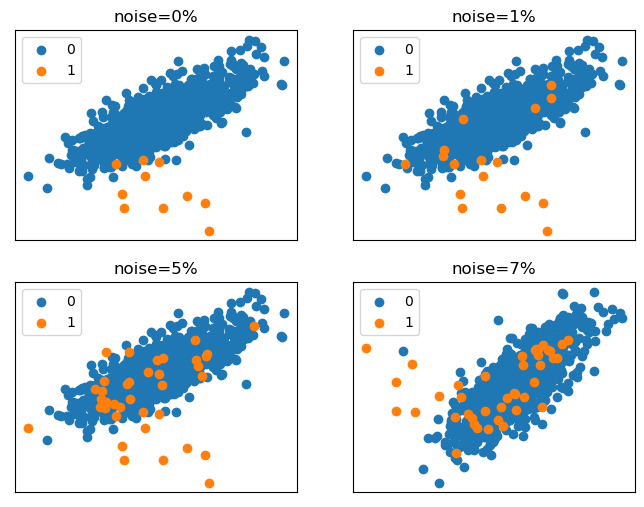

In [7]:
# vary the label noise for a 1:100 imbalanced dataset
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where

# label noise ratios
noise = [0, 0.01, 0.05, 0.07]
# create and plot a dataset with different label noise

for i in range(len(noise)):
    # determine the label noise
    n = noise[i];
    # create the dataset
    X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0,
                               n_clusters_per_class=1, weights=[0.99], flip_y=n, random_state=1);
    # summarize class distribution
    counter = Counter(y);
    print('Noise=%d%%, Ratio=%s' % (int(n*100), counter));
    # define subplot
    pyplot.subplot(2, 2, 1+i);
    pyplot.title('noise=%d%%' % int(n*100));
    pyplot.xticks([]);
    pyplot.yticks([]);
    # scatter plot of examples by class label
    for label, _ in counter.items():
        row_ix = where(y == label)[0];
        pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label));
    pyplot.legend();
# show the figure
pyplot.show();

# Compounding Effect of Data Distribution

Another important consideration is the distribution of examples in feature space. If we think about feature space spatially, we might like all examples in one class to be located on one part of the space, and those from the other class to appear in another part of the space. If this is the case, we have good class separability and machine learning models can draw crisp class boundaries and achieve good classication performance. This holds on datasets with a balanced
or imbalanced class distribution. This is rarely the case, and it is more likely that each class has multiple concepts resulting in multiple dierent groups or clusters of examples in feature space.

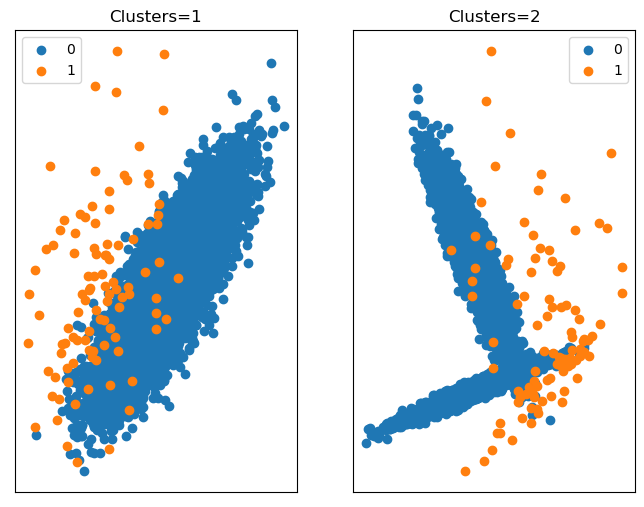

In [8]:
# vary the number of clusters for a 1:100 imbalanced dataset
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where

# number of clusters
clusters = [1, 2]
# create and plot a dataset with different numbers of clusters
for i in range(len(clusters)):
    c = clusters[i];
    # define dataset
    X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
                               n_clusters_per_class=c, weights=[0.99], flip_y=0, random_state=1);
    counter = Counter(y);
    # define subplot
    pyplot.subplot(1, 2, 1+i);
    pyplot.title('Clusters=%d' % c);
    pyplot.xticks([]);
    pyplot.yticks([]);
    # scatter plot of examples by class label
    for label, _ in counter.items():
        row_ix = where(y == label)[0];
        pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label));
    pyplot.legend();
# show the figure
pyplot.show();

# Taxonomy of Classier Evaluation Metrics

1. Threshold Metrics - Threshold metrics are those that quantify the classication prediction errors. That is, they are
designed to summarize the fraction, ratio, or rate of when a predicted class does not match the expected class in a holdout dataset.  Although widely used, classication accuracy is almost universally inappropriate for imbal-
anced classication. The reason is, a high accuracy (or low error) is achievable by a no skill model that only predicts the majority class.  For imbalanced classication problems, the majority class is typically referred to as the negative
outcome (e.g. such as no change or negative test result), and the minority class is typically referred to as the positive outcome (e.g. change or positive test result).

2. Ranking Metrics - Rank metrics are more concerned with evaluating classiers based on how eective they are at
separating classes.  These metrics require that a classier predicts a score or a probability of class membership.
From this score, dierent thresholds can be applied to test the eectiveness of classiers. Those models that maintain a good score across a range of thresholds will have good class separation and will be ranked higher.

3. Probability Metrics - Probabilistic metrics are designed specically to quantify the uncertainty in a classier's
predictions. These are useful for problems where we are less interested in incorrect vs. correct class predictions and more interested in the uncertainty the model has in predictions and penalizing those predictions that are wrong but highly confident.

# How to Choose an Evaluation Metric

Are you predicting probabilities? 

+ Do you need class labels?

    * Is the positive class more important?
    
        · Use Precision-Recall AUC
        
    * Are both classes important?
    
        · Use ROC AUC
        
+ Do you need probabilities?

    * Use Brier Score and Brier Skill Score
    
        · Are you predicting class labels?
        
+ Is the positive class more important?

    * Are False Negatives and False Positives Equally Important?
    
        · Use F1-measure
        
    * Are False Negatives More Important?
    
        · Use F2-measure
        
    * Are False Positives More Important?
    
        · Use F0.5-measure
        
+ Are both classes important?

    * Do you have < 80%-90% Examples for the Majority Class?
    
        · Use Accuracy
        
    * Do you have > 80%-90% Examples for the Majority Class?
    
        · Use G-mean
        
![title](img/ImbalancedClassificationTree.png)        

# The Failure of Accuracy

Classification accuracy is a metric that summarizes the performance of a classification model as the number of correct predictions divided by the total number of predictions.


 Accuracy and error rate are the de facto standard metrics for summarizing the performance
of classification models.

 Classification accuracy fails on classification problems with a skewed class distribution because of the intuitions developed by practitioners on datasets with an equal class
distribution.

 Intuition for the failure of accuracy for skewed class distributions with a worked example.

# What Is Classification Accuracy?

Classification predictive modeling involves predicting a class label given examples in a problem domain. The most common metric used to evaluate the performance of a classification predictive model is classification accuracy. Typically, the accuracy of a predictive model is good (above 90% accuracy), therefore it is also very common to summarize the performance of a model in terms of the error rate of the model.

Another valuable way to think about accuracy is in terms of the confusion matrix. A confusion matrix is a summary of the predictions made by a classification model organized into a table by class. Each row of the table indicates the actual class and each column represents the predicted class. Each table cell value is a count of the number of predictions made for a class that are actually for a given class. The cells on the diagonal represent correct predictions, where a predicted and expected class align.

The confusion matrix provides more insight into not only the accuracy of a predictive model, but also which classes are being predicted correctly, which incorrectly, and what type of errors are being made.

***Classification accuracy is the most-used metric for evaluating classification models. The reason for its wide use is because it is easy to calculate, easy to interpret, and is a single number to summarize the model's capability. As such, it is natural to use it on imbalanced classification problems, where the distribution of examples in the training dataset across the classes is not equal. This is the most common mistake made by beginners to imbalanced classification.***

***Achieving 90 percent classification accuracy, or even 99 percent classification accuracy, may be trivial on an imbalanced classification problem. This means that intuitions for classification accuracy developed on balanced class distributions will be applied and will be wrong, misleading the practitioner into thinking that a model has good or even excellent performance when it, in fact, does not.***

# Example of Accuracy for Imbalanced Classification

Counter({0: 9900, 1: 100})


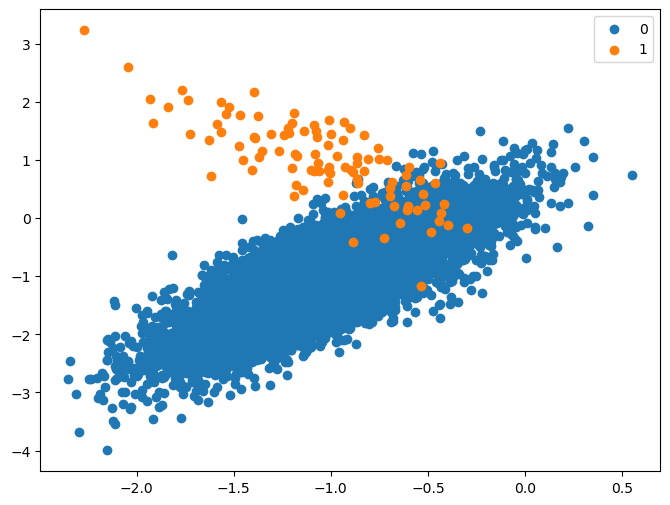

Mean Accuracy: 99.00%


In [9]:
# define an imbalanced dataset with a 1:100 class ratio
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y, model):
    # define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1);
    # evaluate the model on the dataset
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1);
    # return scores from each fold and each repeat
    return scores

# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4);
# summarize class distribution
counter = Counter(y);
print(counter);
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(y == label)[0];
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label));
pyplot.legend();
pyplot.show();

#now attempt to predict the majority class with a simplistic classifier
# define model
model = DummyClassifier(strategy='most_frequent');
# evaluate the model
scores = evaluate_model(X, y, model);
# summarize performance
print('Mean Accuracy: %.2f%%' % (mean(scores) * 100));

# Precision, Recall, and F-measure

Classification accuracy is the total number of correct predictions divided by the total number of predictions made for a dataset. As a performance measure, accuracy is inappropriate for imbalanced classification problems. The main reason is that the overwhelming number of examples from the majority class (or classes) will overwhelm the number of examples in the
minority class, meaning that even unskillful models can achieve accuracy scores of 90 percent, or 99 percent, depending on how severe the class imbalance happens to be. An alternative to using classification accuracy is to use precision and recall metrics.

# Multiclass Classification Precision Measure

In [10]:
# calculates precision for 1:1:100 dataset with 50tp,20fp, 99tp,51fp
from sklearn.metrics import precision_score

# define actual
act_pos1 = [1 for _ in range(100)]                #minority class
act_pos2 = [2 for _ in range(100)]                #minority class
act_neg = [0 for _ in range(10000)]               #majority class
y_true = act_pos1 + act_pos2 + act_neg

# define predictions
pred_pos1 = [0 for _ in range(50)] + [1 for _ in range(50)]
pred_pos2 = [0 for _ in range(1)] + [2 for _ in range(99)]
pred_neg = [1 for _ in range(20)] + [2 for _ in range(51)] + [0 for _ in range(9929)]
y_pred = pred_pos1 + pred_pos2 + pred_neg

# calculate prediction
precision = precision_score(y_true, y_pred, labels=[1,2], average='micro')
print('Precision: %.3f' % precision)

Precision: 0.677


# Recall Measure

Recall is a metric that quanties the number of correct positive predictions made out of all correct positive predictions that could have been made.  Unlike precision that only comments on the correct positive predictions out of all positive predictions, recall provides an indication of missed positive predictions. In this way, recall provides some notion of the coverage of the positive class.

# Multiclass Classification Recall Measure

In [11]:
# calculates recall for 1:1:100 dataset
from sklearn.metrics import recall_score

# define actual
act_pos1 = [1 for _ in range(100)]   #minority
act_pos2 = [2 for _ in range(100)]   #minority
act_neg = [0 for _ in range(10000)]  #majority
y_true = act_pos1 + act_pos2 + act_neg

# define predictions
pred_pos1 = [0 for _ in range(23)] + [1 for _ in range(77)]
pred_pos2 = [0 for _ in range(5)] + [2 for _ in range(95)]
pred_neg = [0 for _ in range(10000)]
y_pred = pred_pos1 + pred_pos2 + pred_neg

# calculate recall
recall = recall_score(y_true, y_pred, labels=[1,2], average='micro')
print('Recall: %.3f' % recall)

Recall: 0.860


# Precision vs. Recall

You may decide to use precision or recall on your imbalanced classification problem. Maximizing precision will minimize the number false positive errors, whereas maximizing the recall will
minimize the number of false negative errors. As such, precision may be more appropriate on classification problems when false positives are more important. Alternately, recall may be more
appropriate on classification problems when false negatives are more important. 

 Precision: Appropriate when minimizing false positives is the focus.
    
 Recall: Appropriate when minimizing false negatives is the focus.

# F-measure

Classification accuracy is widely used because it is one single measure used to summarize model performance. F-measure provides a way to combine both precision and recall into a single measure that captures both properties. Alone, neither precision or recall tells the whole story. We can have excellent precision with terrible recall, or alternately, terrible precision with excellent recall. F-measure provides a way to express both concerns with a single score. Once precision and recall have been calculated for a binary or multiclass classication problem, the two scores can be combined into the calculation of the F-measure.

In [12]:
# Multiclass Classification F-measure

In [13]:
# calculates f1 for 1:100 dataset 
from sklearn.metrics import f1_score

# define actual
act_pos = [1 for _ in range(100)]
act_pos2= [1 for _ in range(100)]
act_neg = [0 for _ in range(10000)]
y_true = act_pos + act_pos2 + act_neg

# define predictions
pred_pos = [0 for _ in range(5)] + [1 for _ in range(95)]
pred_pos2= [0 for _ in range(5)] + [1 for _ in range(95)]
pred_neg = [1 for _ in range(55)] + [0 for _ in range(9945)]
y_pred = pred_pos + pred_pos2 + pred_neg

# calculate score
score = f1_score(y_true, y_pred, average='binary')
print('F-measure: %.3f' % score)

F-measure: 0.854


# Fbeta-Measure

The F-measure balances the precision and recall. On some problems, we might be interested in an F-measure with more attention put on precision, such as when false positives are more important to minimize, but false negatives are still important. On other problems, we might be interested in an F-measure with more attention put on recall, such as when false negatives are more important to minimize, but false positives are still important. The solution is the Fbeta-measure (FBeta-measure). The Fbeta-measure is an abstraction of the F-measure where the balance of precision and recall in the calculation of the harmonic mean is controlled by a coeficient called beta (BETA).

The choice of the Beta parameter will be used in the name of the Fbeta-measure. For example, a BETA value of 2 is referred to as F2-measure or F2-score. A BETA value of 1 is referred to as the F1-measure or the F1-score. Three common values for the beta parameter are as follows: 

 F0.5-measure (BETA = 0:5): More weight on precision, less weight on recall.

 F1-measure (BETA = 1): Balance the weight on precision and recall.

 F2-measure (BETA = 2): Less weight on precision, more weight on recall.

The scikit-learn library provides the fbeta score() for calculating the Fbeta-measure for a
set of predictions and accepts a beta argument that can be set to the common values of 0.5 or 2.